In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
import OAPBuoyData as OAP, commonfxns as cf, diagsPP, viz
import cftime
import OAPBuoyComp as bc
import cmocean
import datetime as dt

/home/ords/crd/ccrn/reo000/miniconda3/envs/py39dc2/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
pathch='/space/hall5/sitestore/eccc/crd/ccrn/users/rpg002/data/chlos/observations/ESACCI/raw/raw/'
fch0=sorted(os.listdir(pathch))
fch=xr.open_mfdataset([os.path.join(pathch,el) for el in fch0])
fch

<xarray.Dataset> Size: 470GB
Dimensions:             (time: 315, lat: 4320, lon: 8640)
Coordinates:
  * lat                 (lat) float64 35kB 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                 (lon) float64 69kB -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                (time) datetime64[ns] 3kB 1998-01-01 ... 2024-03-01
Data variables:
    MERIS_nobs_sum      (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    MODISA_nobs_sum     (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    OLCI-A_nobs_sum     (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    OLCI-B_nobs_sum     (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    SeaWiFS_nobs_sum    (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    VIIRS_nobs_sum      (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    chlor_a             (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    chlor_a_log10_bias  (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    chlor_a_log10_rmsd  (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    crs                 (time) int32 1kB -2147483647 -2147483647 ... -2147483647
    total_nobs_sum      (time, lat, lon) float32 47GB dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
Attributes: (12/51)
    Conventions:                       CF-1.7
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    creator_email:                     help@esa-oceancolour-cci.org
    creator_name:                      Plymouth Marine Laboratory
    ...                                ...
    history:                           Source data were: ESACCI-OC-L3S-OC_PRO...
    netcdf_file_type:                  NETCDF4_CLASSIC
    id:                                ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHL...
    source:                            NASA SeaWiFS  L1A and L2 R2018.0 LAC a...
    summary:                           Data products generated by the Ocean C...
    tracking_id:                       cfab3ba2-2e77-424f-b379-4cb822ca270a

In [3]:
fch['chlor_a']

<xarray.DataArray 'chlor_a' (time: 315, lat: 4320, lon: 8640)> Size: 47GB
dask.array<concatenate, shape=(315, 4320, 8640), dtype=float32, chunksize=(1, 270, 270), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 35kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float64 69kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 3kB 1998-01-01 1998-02-01 ... 2024-03-01
Attributes:
    ancillary_variables:  chlor_a_log10_rmsd chlor_a_log10_bias
    long_name:            Chlorophyll-a concentration in seawater (not log-tr...
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass_concentration_of_chlorophyll_a_in_sea_water
    units:                milligram m-3
    units_nonstandard:    mg m^-3

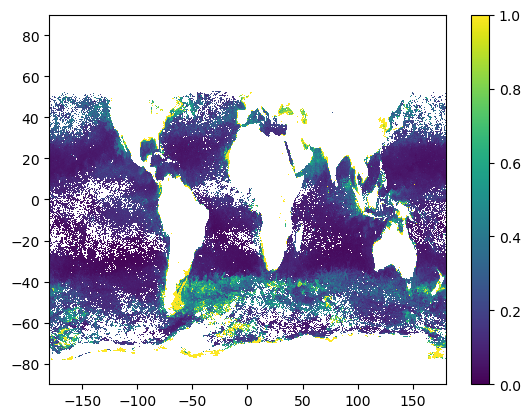

In [4]:
plt.pcolormesh(fch.lon,fch.lat,fch.chlor_a[0,:,:],vmin=0,vmax=1)
plt.colorbar()

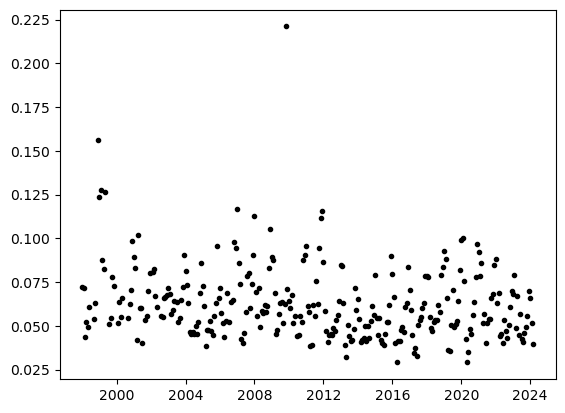

In [5]:
plt.plot(fch.time,fch['chlor_a'].sel(lat=25,lon=-130,method='nearest'),'k.')

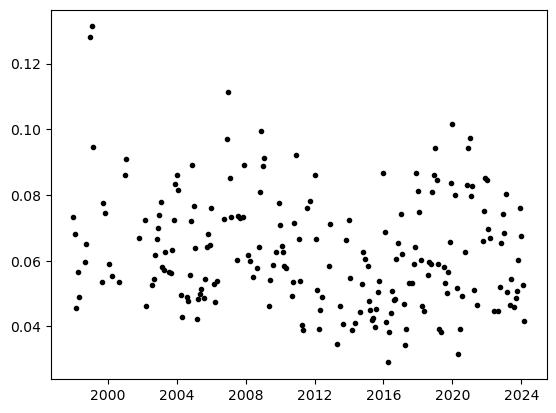

In [6]:
data=fch['chlor_a'].sel(lat=slice(25+.5,25-.5),lon=slice(-130-.5,-130+.5)).values
plt.plot(fch.time,np.reshape(data,(len(fch.time),-1)).mean(axis=-1),'k.')

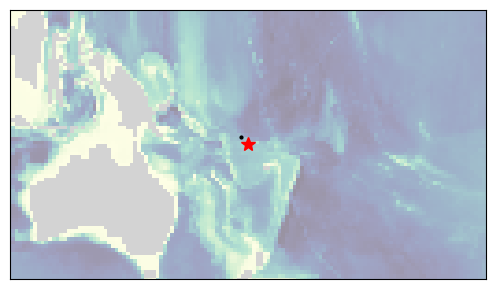

In [7]:
def _makemap(ax,ii,jj,iis,jjs):
    v0=0; v1=6500
    cmap=cmocean.cm.deep
    cmap.set_bad('darkgray')
    m=ax.pcolormesh(viz.deptho1x1,shading='auto',vmin=v0,vmax=v1,cmap=cmap,alpha=.5)
    ax.plot(iis,jjs,'k.',ms=4)
    ax.plot(ii,jj,'r*',ms=10)
    ax.set_aspect(1)
    ax.set_xticks([])
    ax.set_yticks([])
    [lh,lw]=np.shape(viz.deptho1x1)
    ww=lw/2.8
    hh=lh/4
    xcen=min(max(ww/2,ii),lw-ww/2)
    ycen=min(max(hh/2,jj),lh-hh/2)
    ax.axis([xcen-ww/2,xcen+ww/2,ycen-hh/2,ycen+hh/2])
    return
fig,ax=plt.subplots(1,1,figsize=(8,3.5))
_makemap(ax,100,120,[100,98,20],[120,122,105])

In [8]:
compsD=bc.loadAllComps(compsdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/CanESM51_1975_2022/comps/',freq='daily')
compsM=bc.loadAllComps(compsdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/CanESM51_1975_2022_monthly/comps/',freq='monthly')
compsMC=bc.loadAllComps(compsdir='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/CanESM5CanOE_1975_2022_monthly/comps/',freq='monthly')

In [9]:
with xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/sos_Oday_CanESM5-1_historical_r1i1p2f1_gn_19710101-19801231.nc') as fS:
    print(fS['sos'])

<xarray.DataArray 'sos' (time: 3650, j: 291, i: 360)> Size: 2GB
[382374000 values with dtype=float32]
Coordinates:
  * time       (time) object 29kB 1971-01-01 12:00:00 ... 1980-12-31 12:00:00
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 838kB ...
    longitude  (j, i) float64 838kB ...
Attributes:
    standard_name:  sea_surface_salinity
    long_name:      Sea Surface Salinity
    comment:        Sea water salinity is the salt content of sea water, ofte...
    units:          0.001
    original_name:  sos
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello


Question: What scale is SSS on here? psu? TEOS10 S_A?

In [10]:
with xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/chlos_Omon_CanESM5-1_historical_r1i1p2f1_gn_185001-201412.nc') as fS:
    print(fS['chlos'])

<xarray.DataArray 'chlos' (time: 1980, j: 291, i: 360)> Size: 830MB
[207424800 values with dtype=float32]
Coordinates:
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 838kB ...
    longitude  (j, i) float64 838kB ...
Attributes:
    standard_name:  mass_concentration_of_phytoplankton_expressed_as_chloroph...
    long_name:      Surface Mass Concentration of Total Phytoplankton Express...
    comment:        Sum of chlorophyll from all phytoplankton group concentra...
    units:          kg m-3
    original_name:  NCHL
    history:        deptht_l1_mltby1em6
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello


In [11]:
with xr.open_dataset('/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/spco2_Omon_CanESM5-1_historical_r1i1p2f1_gn_185001-201412.nc') as fS:
    print(fS['spco2'])

<xarray.DataArray 'spco2' (time: 1980, j: 291, i: 360)> Size: 830MB
[207424800 values with dtype=float32]
Coordinates:
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 283 284 285 286 287 288 289 290
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 838kB ...
    longitude  (j, i) float64 838kB ...
    depth      float64 8B ...
Attributes:
    standard_name:  surface_partial_pressure_of_carbon_dioxide_in_sea_water
    long_name:      Surface Aqueous Partial Pressure of CO2
    comment:        The surface called 'surface' means the lower boundary of ...
    units:          Pa
    original_name:  spco2
    history:        mltby0.101325 2022-11-22T04:17:16Z altered by CMOR: Treat...
    cell_methods:   area: mean where sea time: mean
    cell_measures:  area: areacello


In [12]:
list(compsD.keys())[0]

('pmel_co2_moorings_0088_00e7_268c', 'sos', 'daily')

In [13]:
compsD[list(compsD.keys())[0]]

evalfxns.timeSeriesComp(
	 modvar=sos, stationID=pmel_co2_moorings_0088_00e7_268c, staname=CRIMP1  NOAA Surface Ocean CO2 and Ocean Acidification Mooring Time Series, freq=daily
	 other instance variables:version,shortTitle,shortID,lat,lon,savepath,figsavepath,compsavepath,tref,yrfaco,yrfacm,mlen,obs_tdt,obs_val,dispName,dispUnits,dispNameUnits,obsvar,mod_tnl,mod_tdt,mod_val,obs_yd,obs_ym,iiOLo,mod_yd,mod_ym,mod_yind,obs_yind,fityrlen,iiOLm,obs_trange,mod_trange,OL_trange,trange,defaultfit,modfits,obsfits,mod_targetdind,obs_targetdind,target_datetime,mod_target,obs_target,obs_target_b,mod_targetdeseas,obs_targetdeseas,obs_targetdeseas_b,mod_gsmooth,obs_gsmooth,obs_gsmooth_b,modfitlist,stats,mod_tind,obs_tind,obs_tind_b,mod_intt,obs_intt)

In [14]:
iii=2
np.mean(compsD[list(compsD.keys())[iii]].mod_targetdeseas),np.mean(compsD[list(compsD.keys())[iii]].mod_target),\
    np.nanmean(compsD[list(compsD.keys())[iii]].obs_targetdeseas),np.nanmean(compsD[list(compsD.keys())[iii]].obs_target),

(36.65867063602091, 36.658670636020915, 36.111249858900514, 36.145386225354464)

In [15]:
list(compsM.keys())[0]

('pmel_co2_moorings_0088_00e7_268c', 'AOUos', 'monthly')

In [16]:
dfb=OAP.loadOAPInfo(modelgrid=True)
dfb.keys()

Index(['datasetID', 'title', 'minTime', 'maxTime', 'Lat', 'Lon', 'tabfile',
       'jj', 'ii', 'Lat1x1', 'Lon1x1', 'jjHD', 'iiHD', 'modBathy',
       'modBathyHD', 'shortTitle'],
      dtype='object')

In [17]:
mdvec=[(dt.datetime(2015,mm,15)-dt.datetime(2014,12,31)).total_seconds()/(24*3600) for mm in range(1,13)]

In [18]:
mlist=np.array([el%12+1 for el in range(0,len(fch.time))])

Note: satellite chl lines below are not trend-adjusted to observation period, in part because chl trends are generally small compared to interannual variability

/tmp/reo000/374255/ipykernel_818580/2587602550.py:9: RuntimeWarning: Mean of empty slice
  iax.plot(vec,c.obs_gsmooth+np.nanmean(c.obs_targetdeseas),'r-')
/tmp/reo000/374255/ipykernel_818580/2587602550.py:21: RuntimeWarning: Mean of empty slice
  data1=np.nanmean(np.reshape(data,(len(chfile.time),-1)),axis=-1)
/tmp/reo000/374255/ipykernel_818580/2587602550.py:23: RuntimeWarning: Mean of empty slice
  iax.plot(np.arange(1,13),[np.nanmean(data0[el::12]) for el in range(0,12)],'-',color='purple',alpha=.5)
/tmp/reo000/374255/ipykernel_818580/2587602550.py:24: RuntimeWarning: Mean of empty slice
  iax.plot(np.arange(1,13),[np.nanmean(data1[el::12]) for el in range(0,12)],'-',color='darkorange',alpha=.5)
/tmp/reo000/374255/ipykernel_818580/2587602550.py:7: RuntimeWarning: divide by zero encountered in divide
  iax.plot(c.obs_yind+.2,c.obs_val,'r.',ms=2,alpha=min(.01*(2023-1975)*365/nobs,.5),label='Buoy')
/tmp/reo000/374255/ipykernel_818580/2587602550.py:2: RuntimeWarning: More than 20 figure

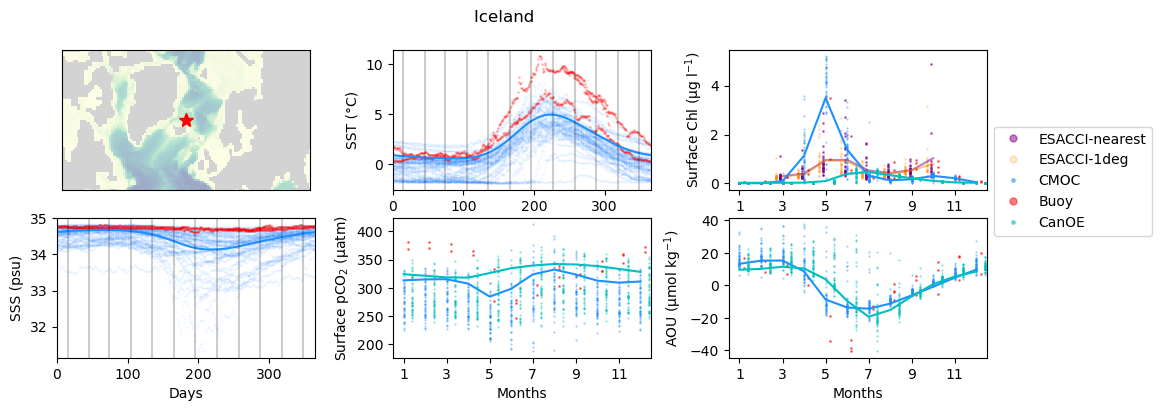

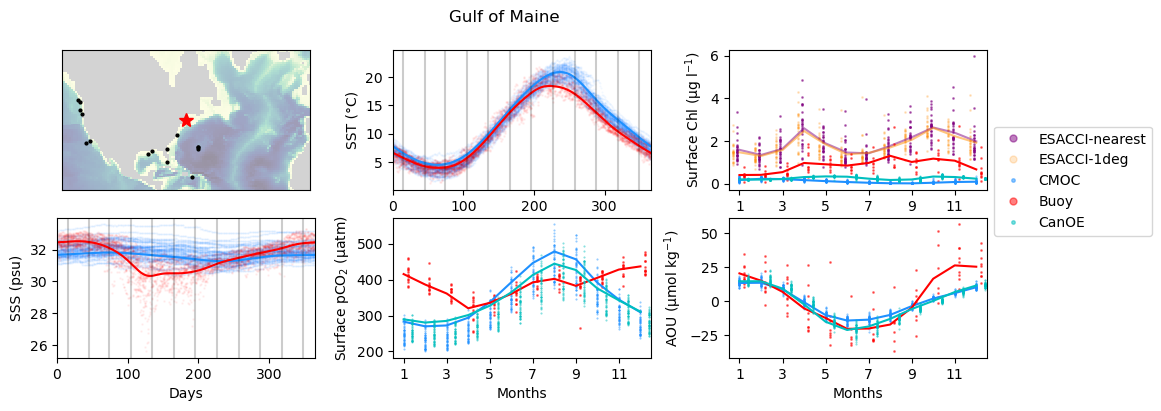

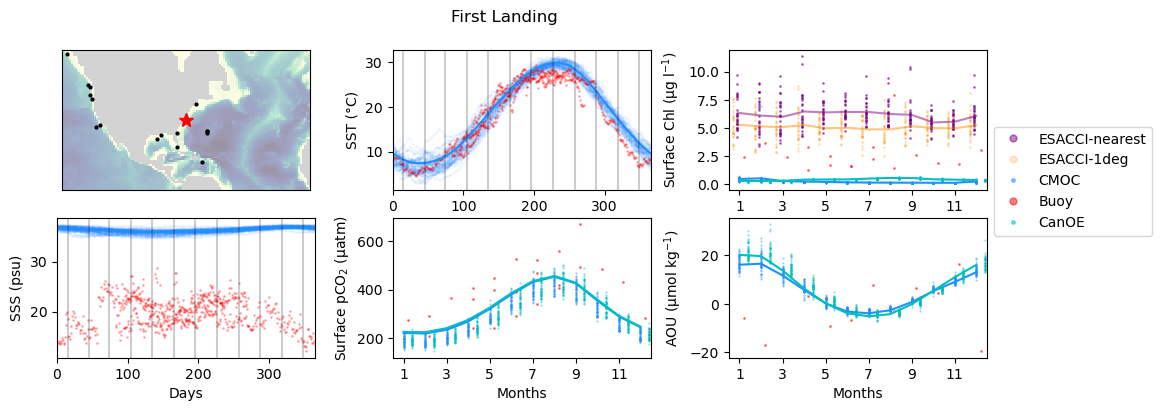

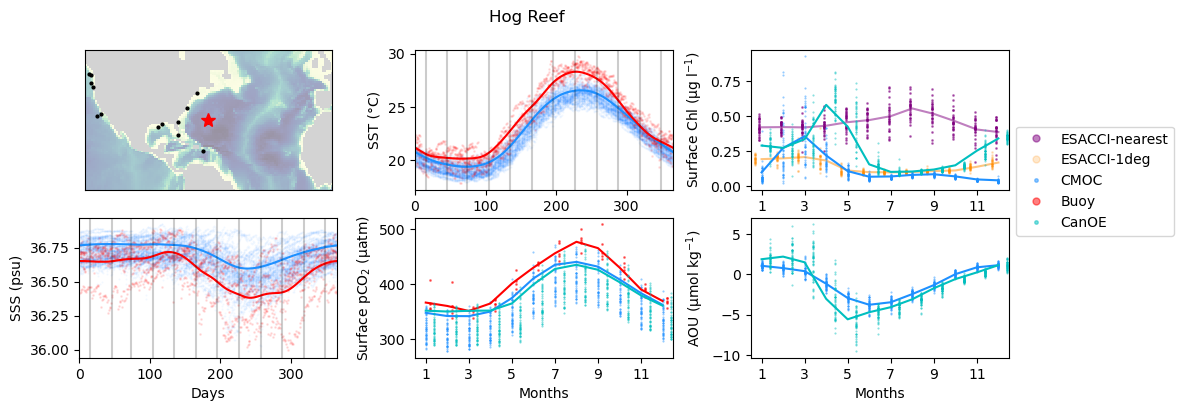

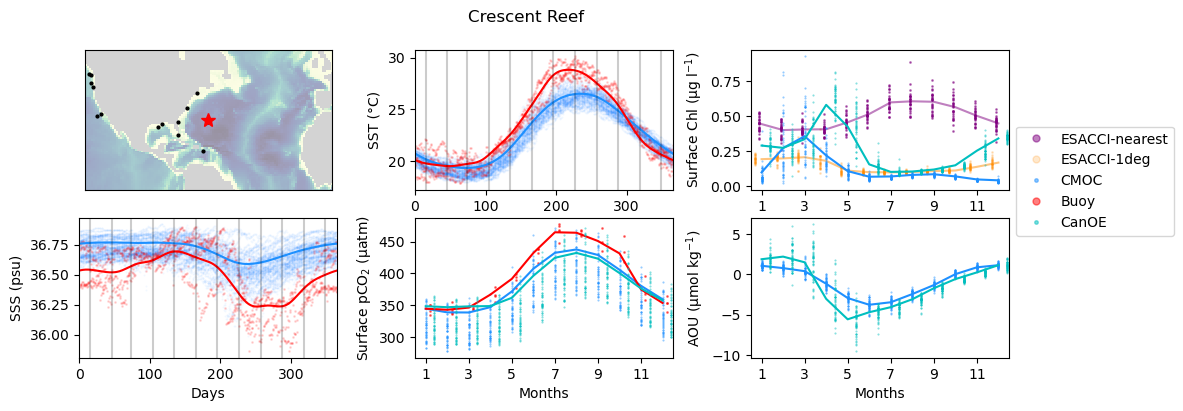

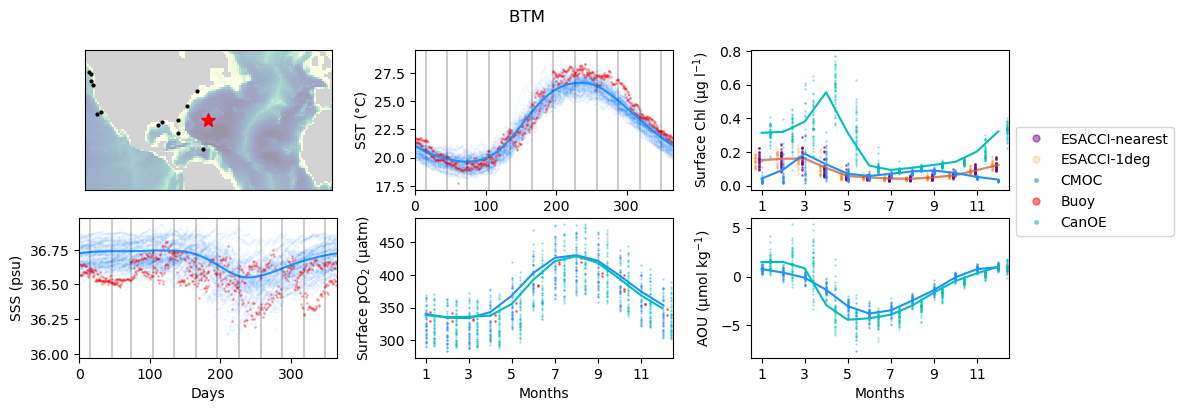

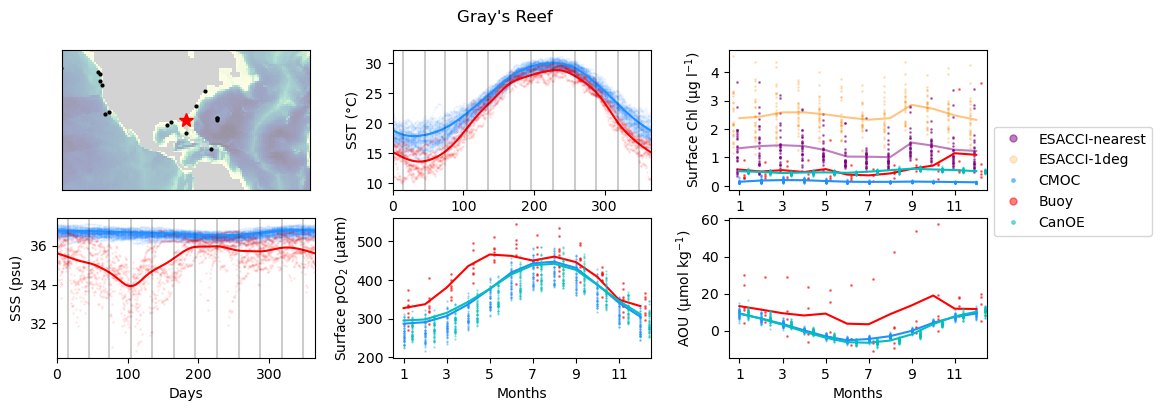

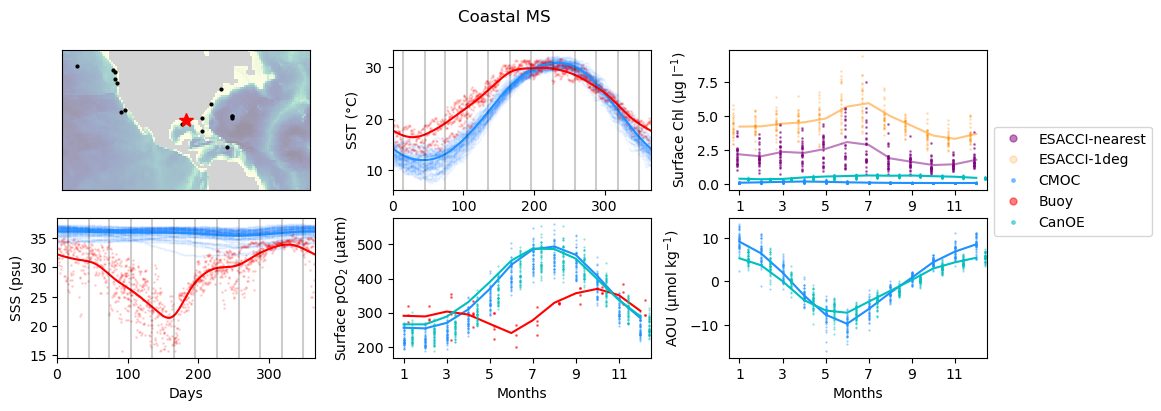

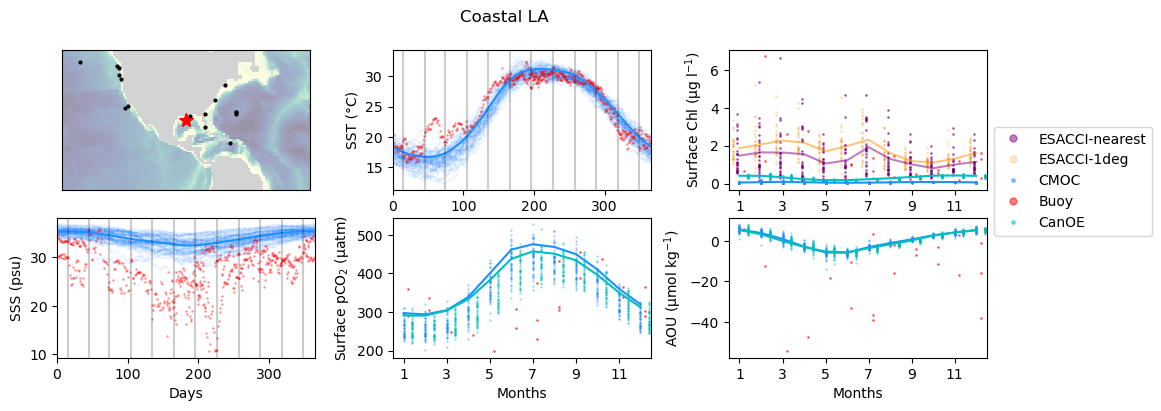

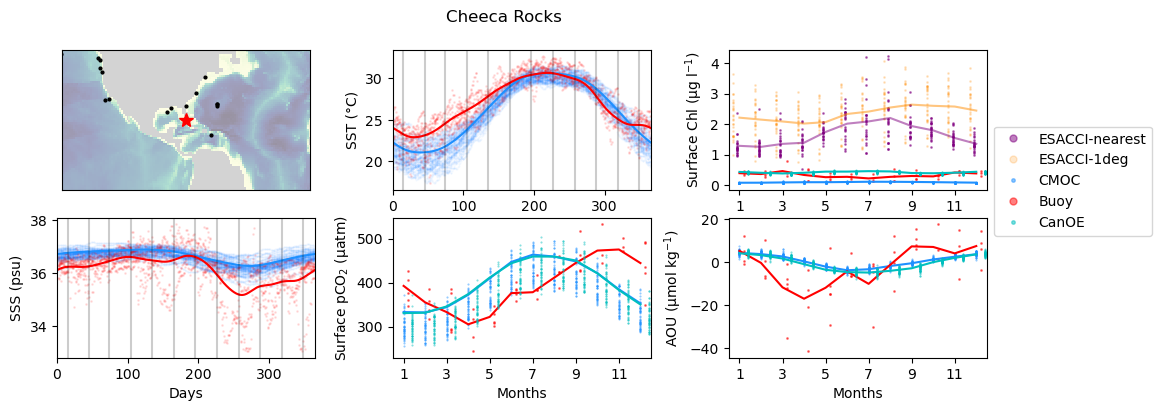

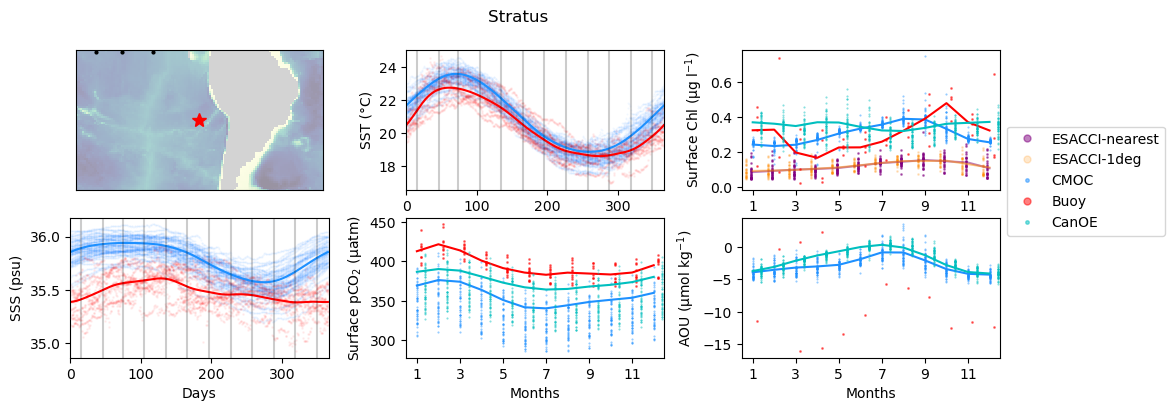

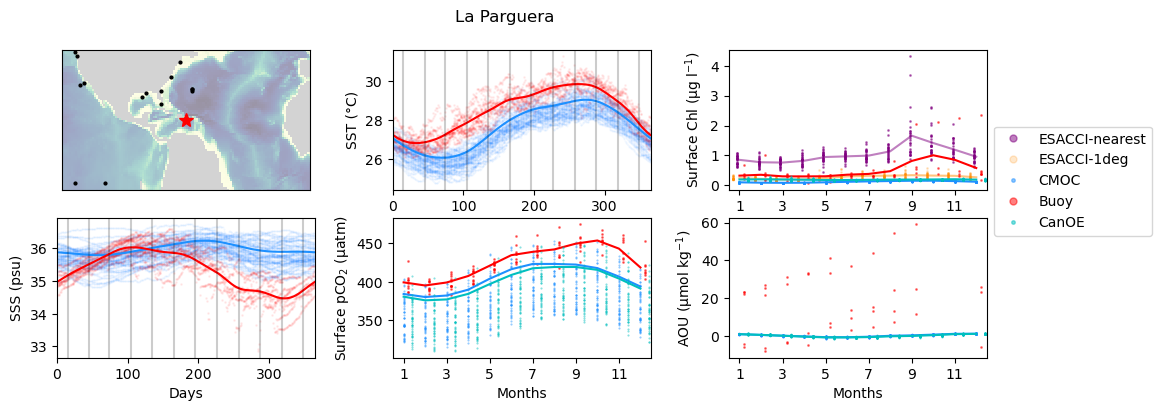

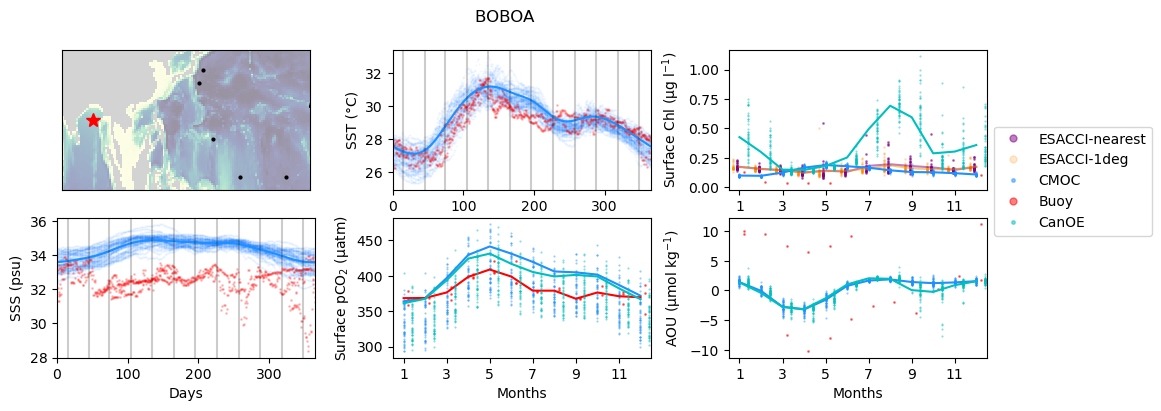

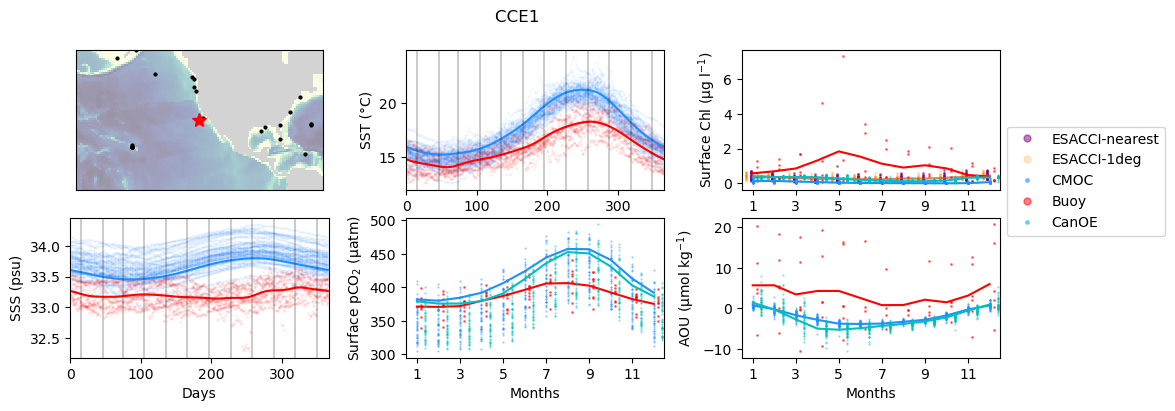

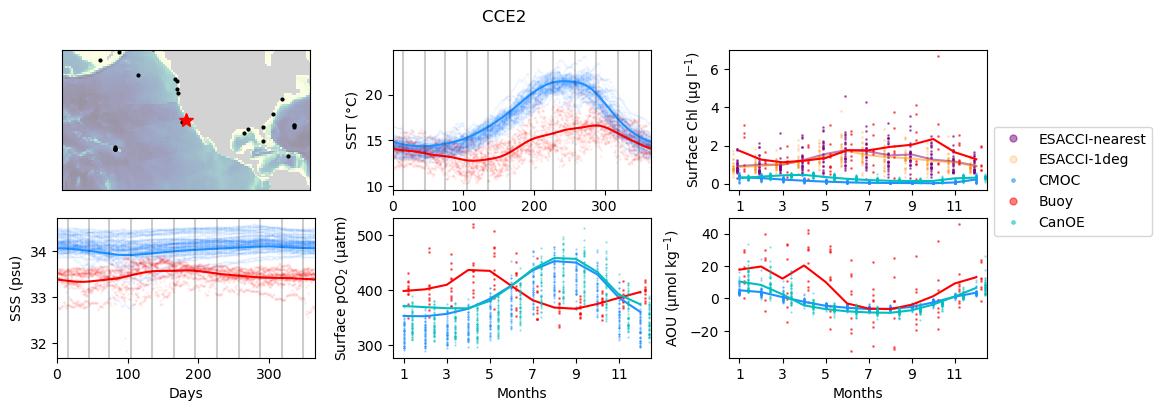

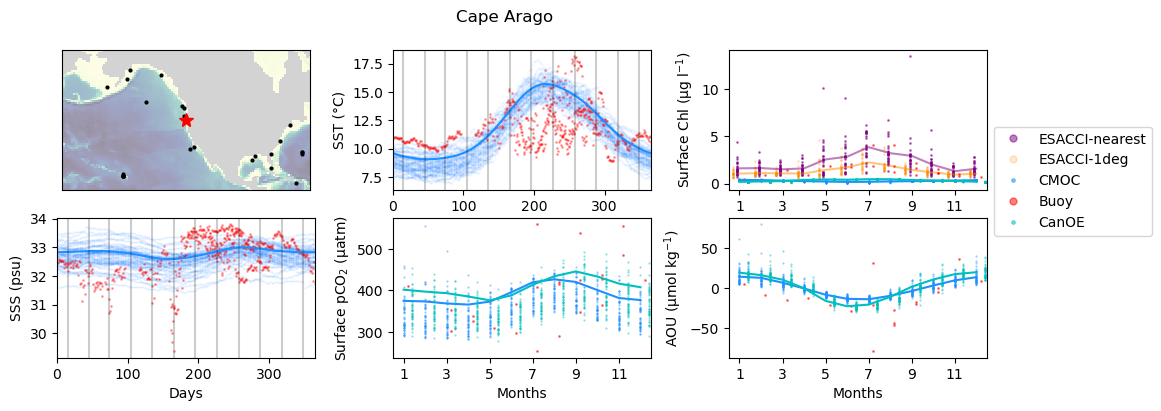

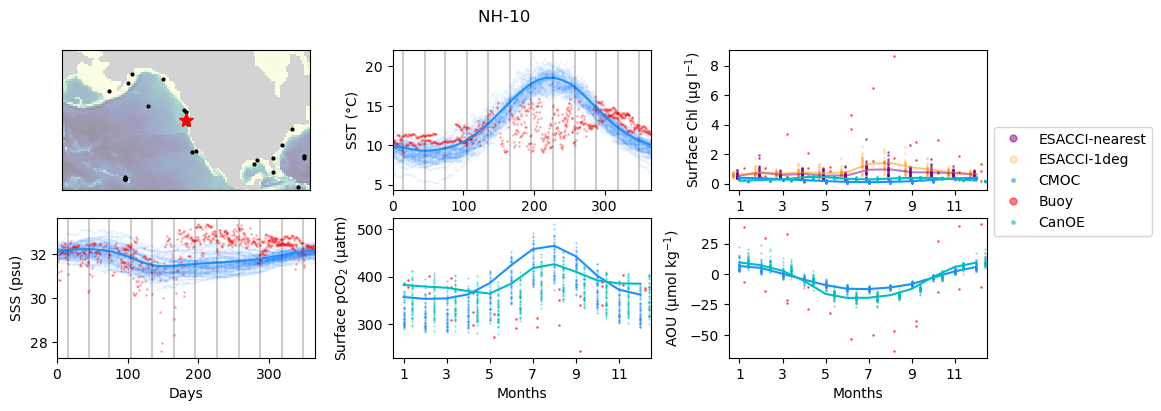

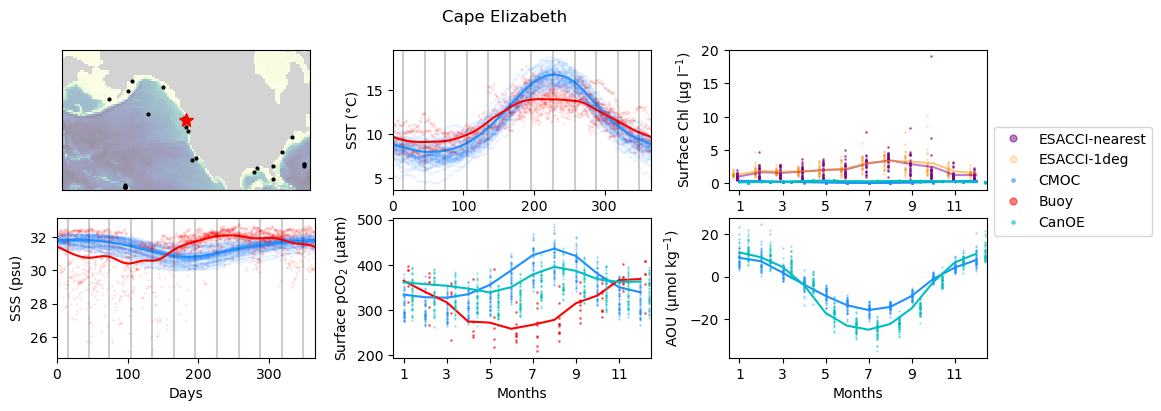

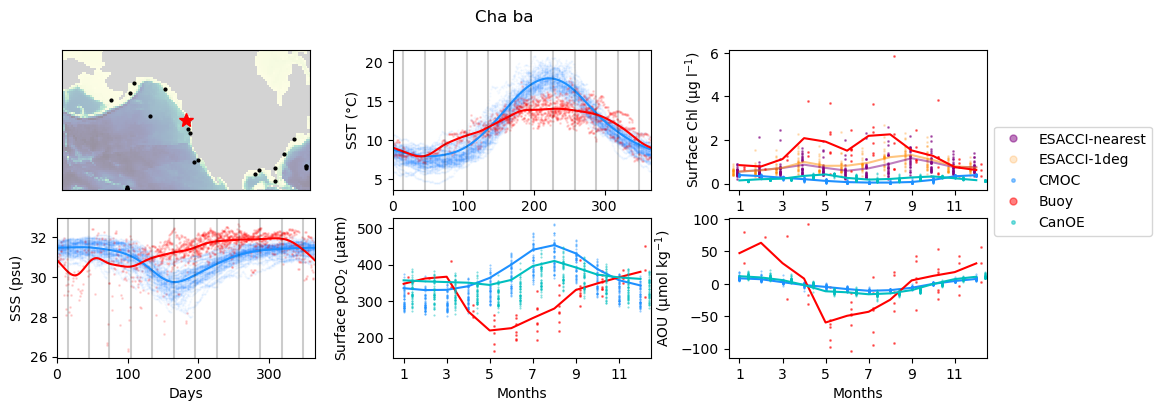

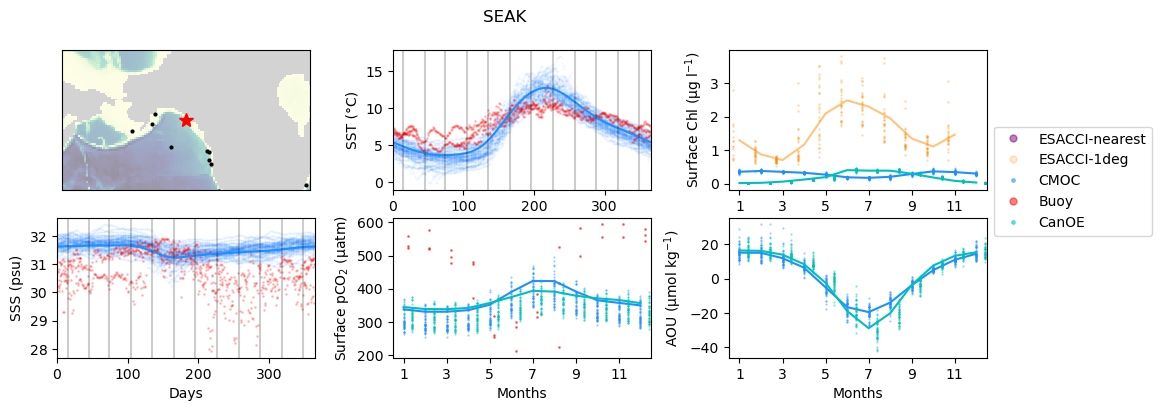

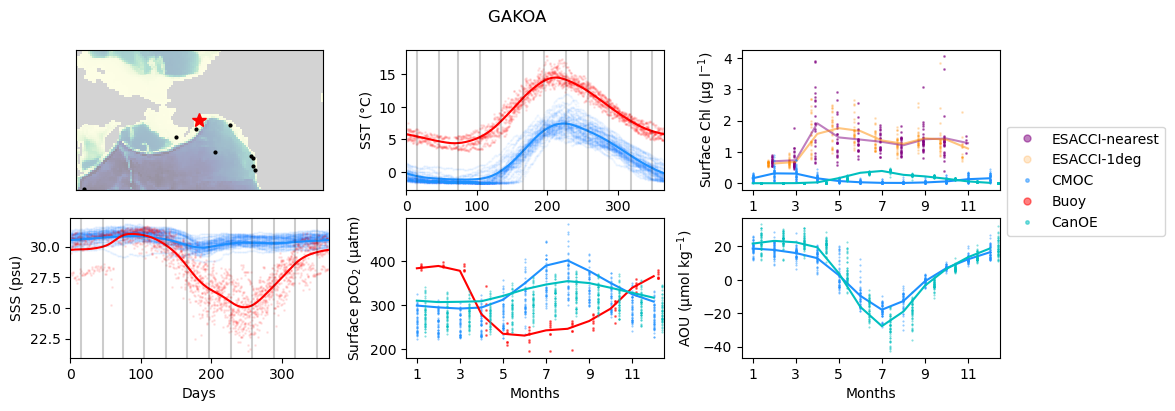

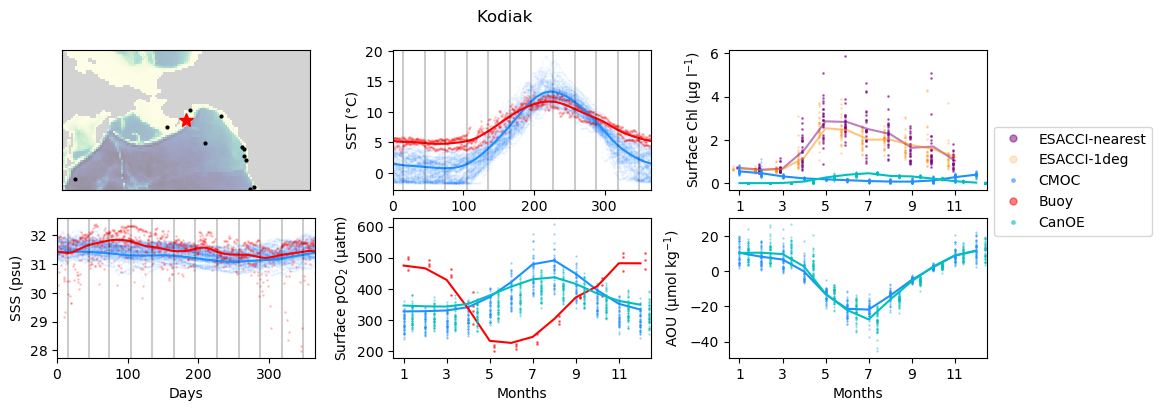

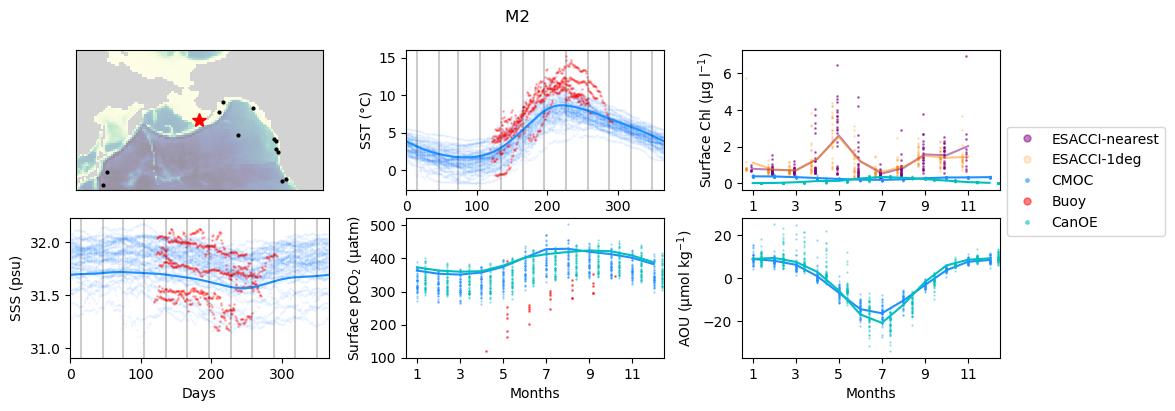

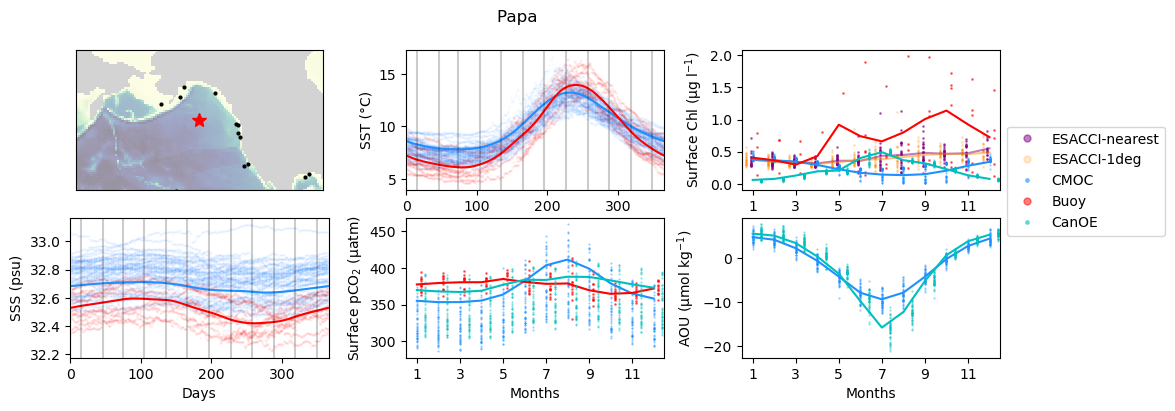

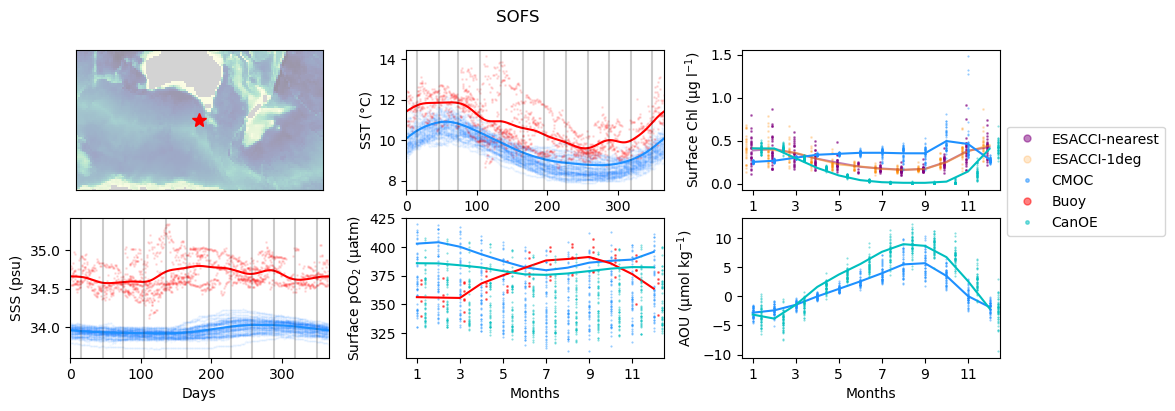

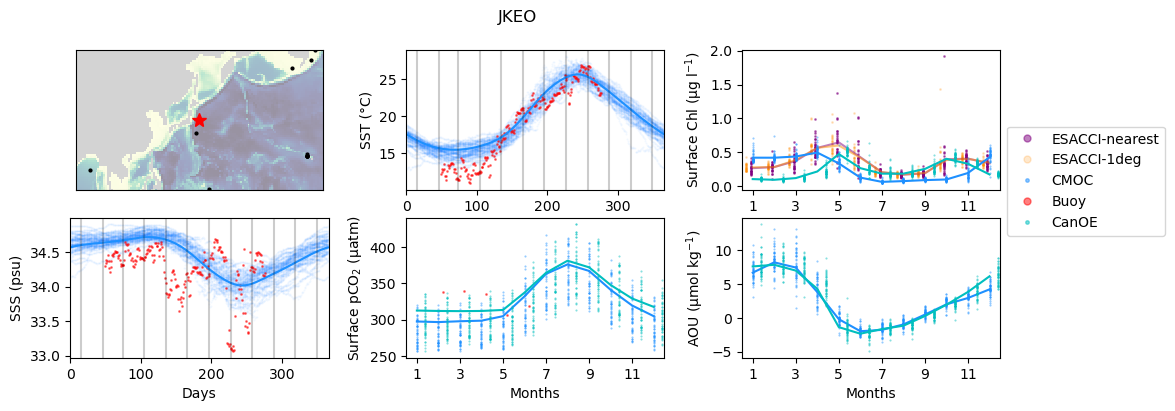

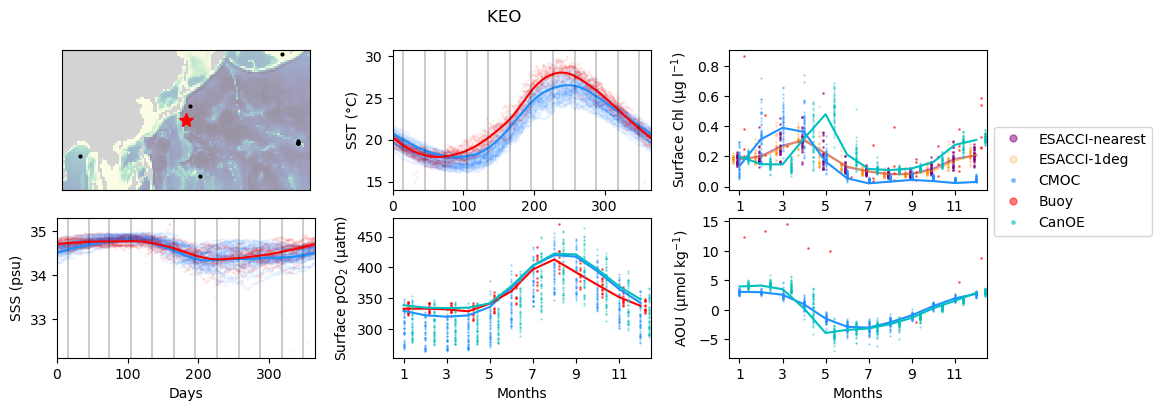

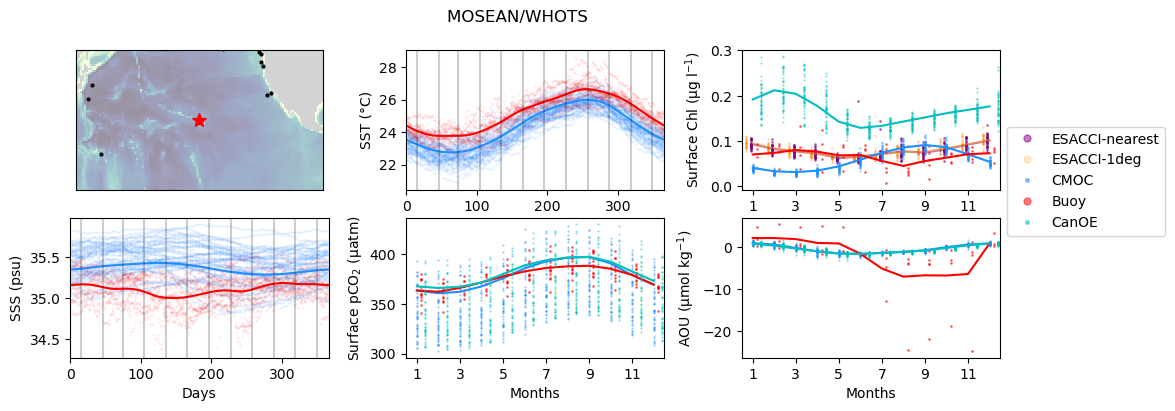

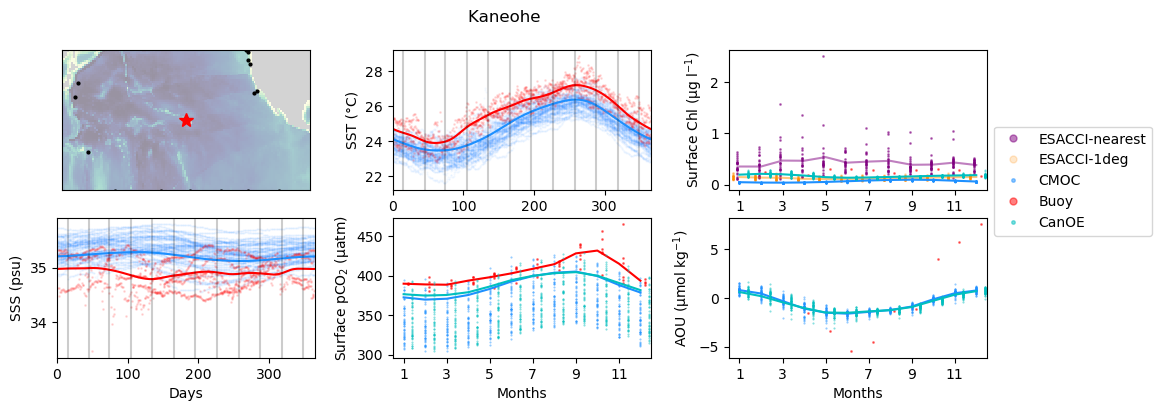

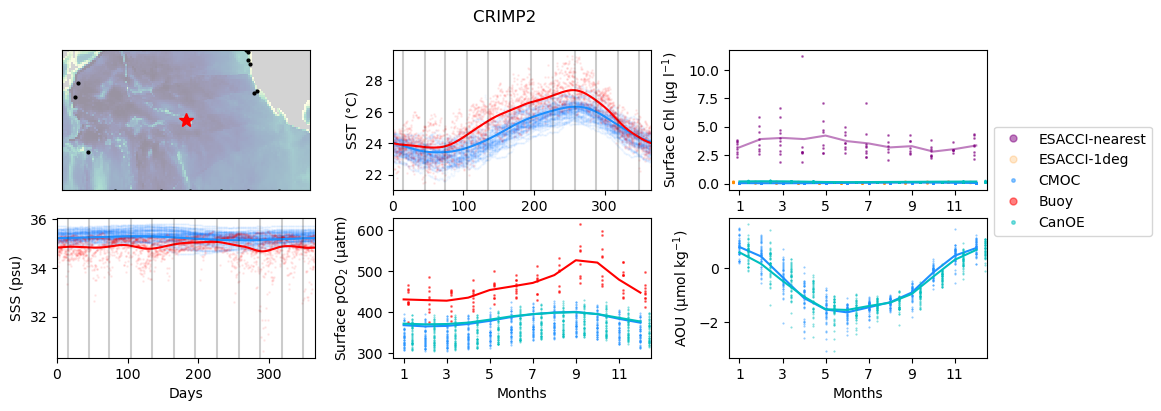

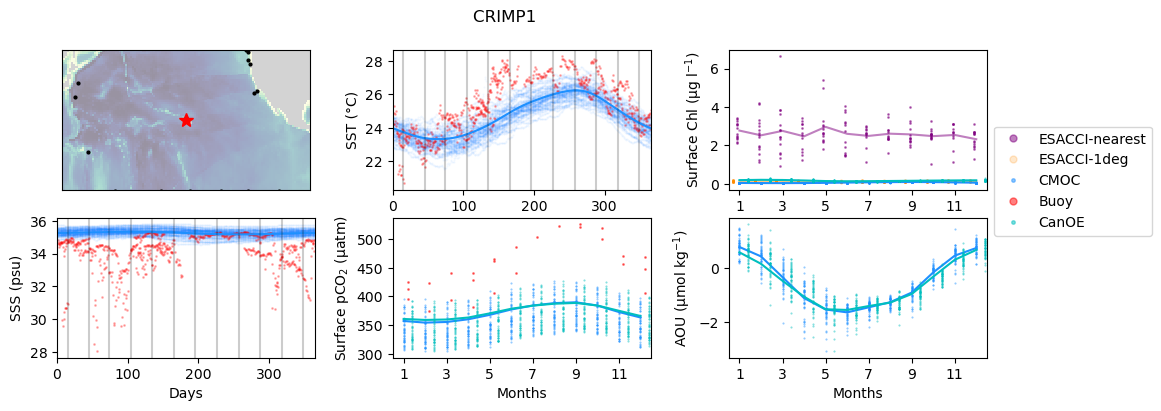

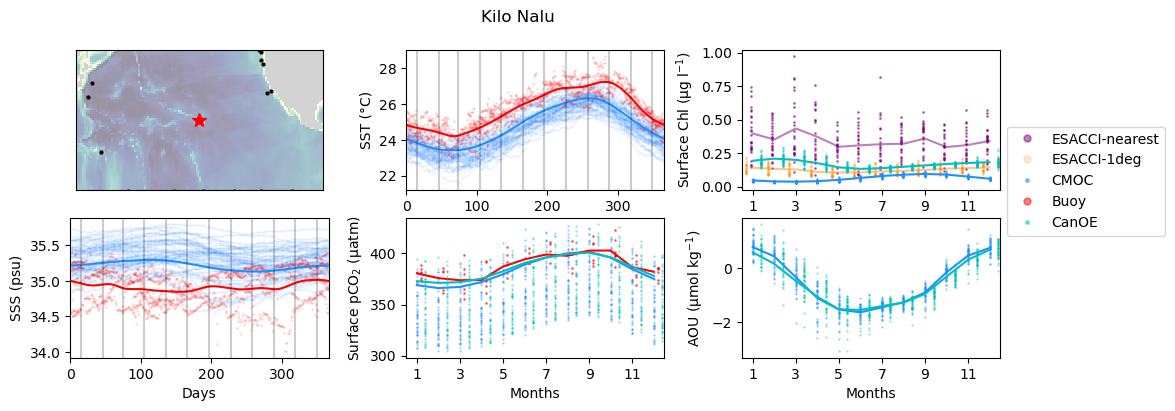

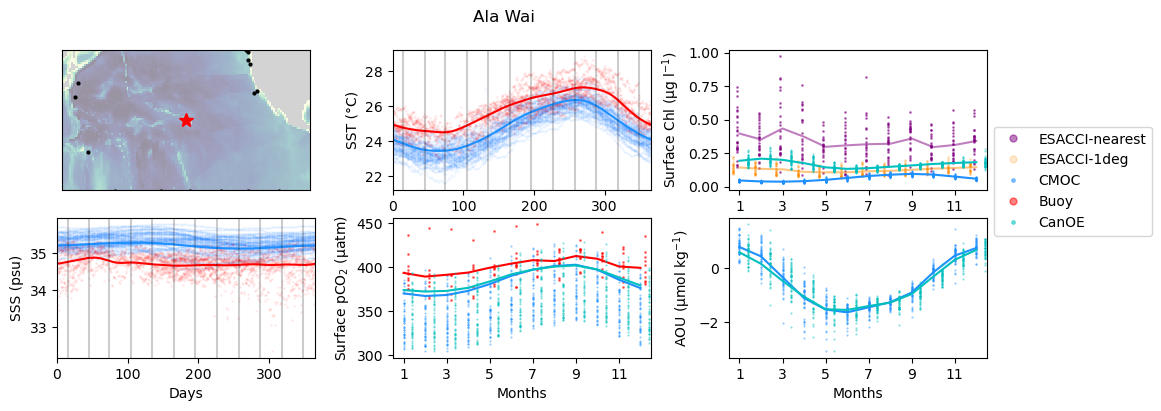

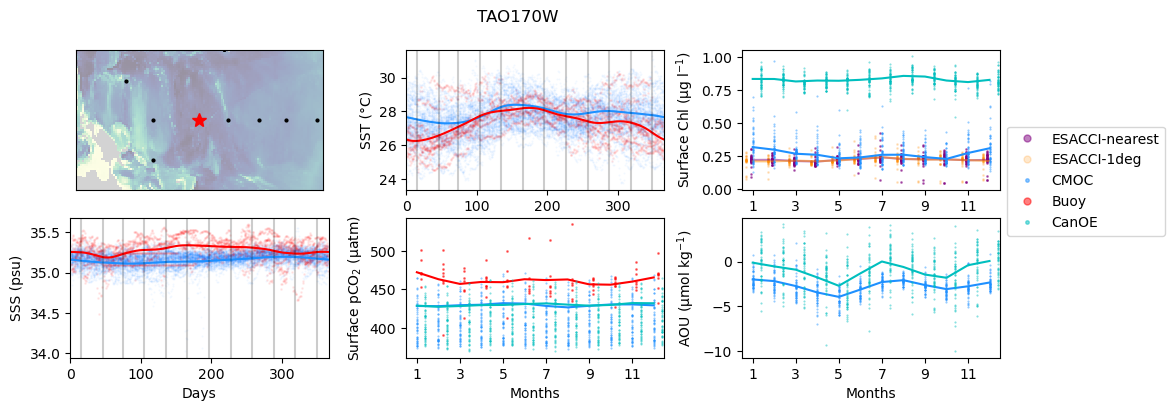

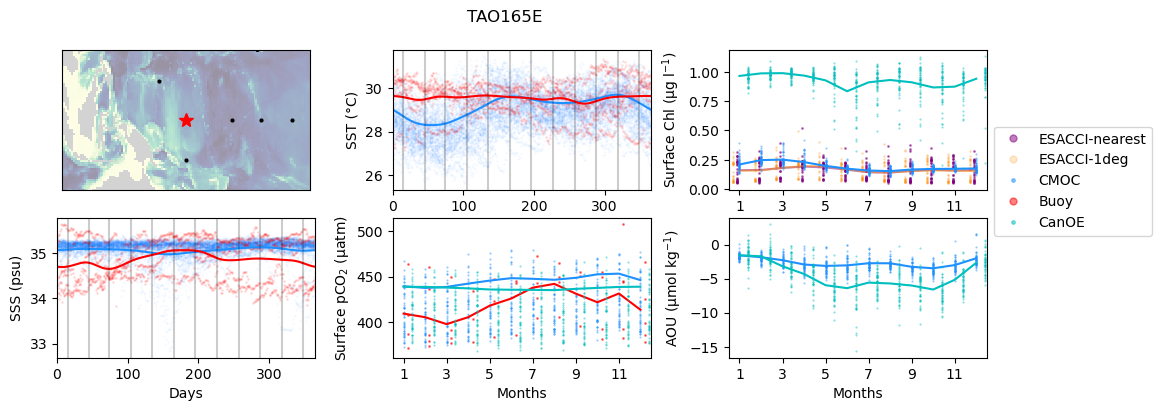

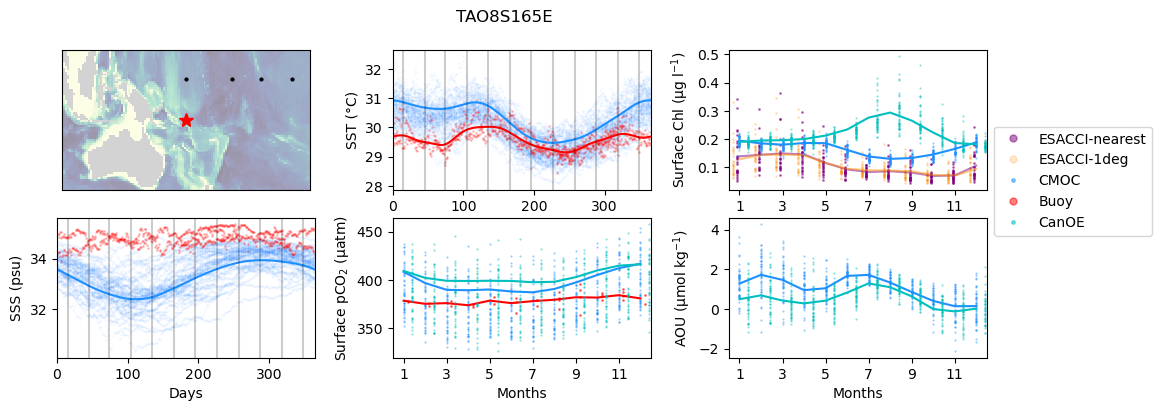

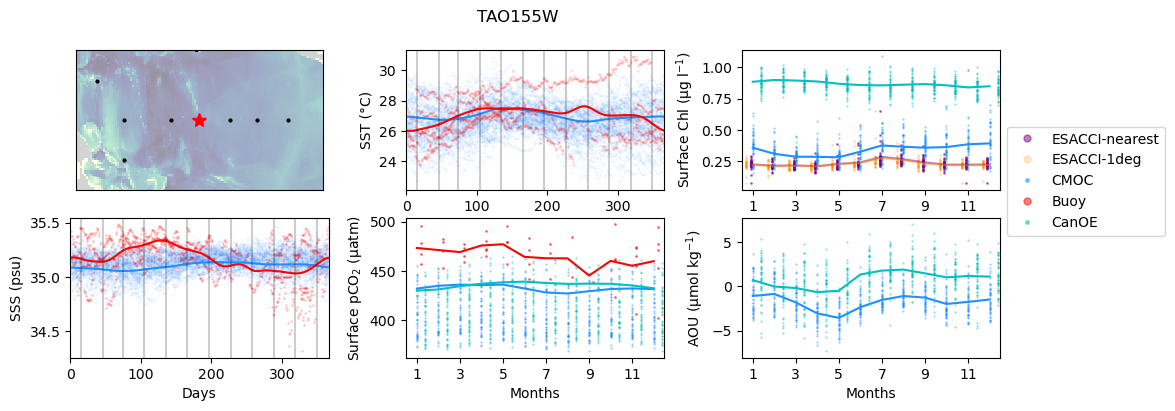

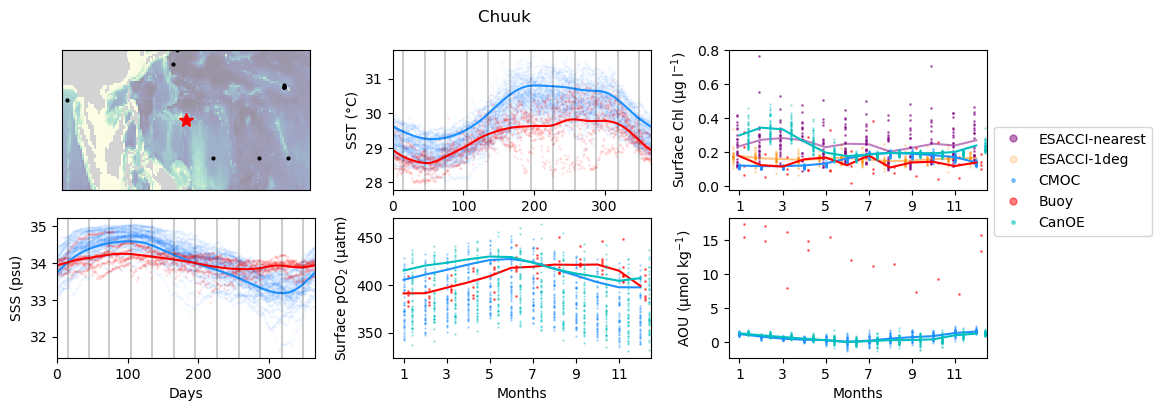

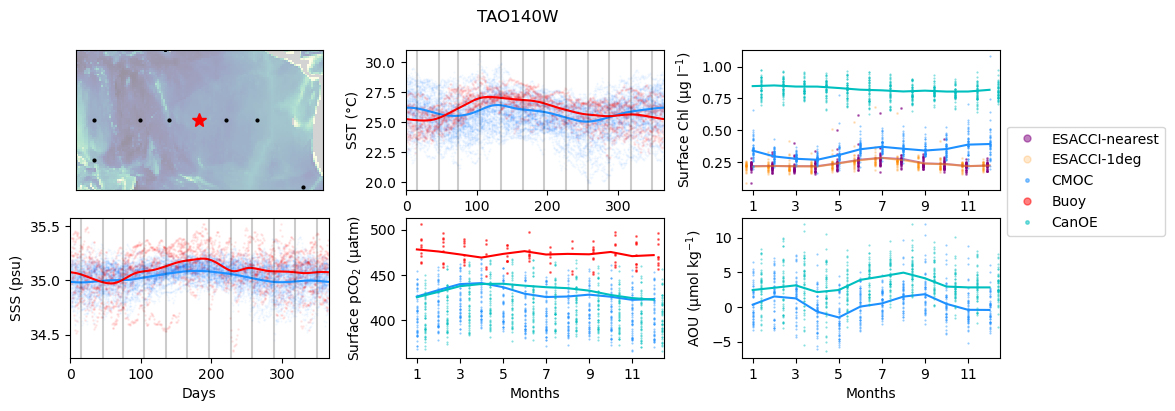

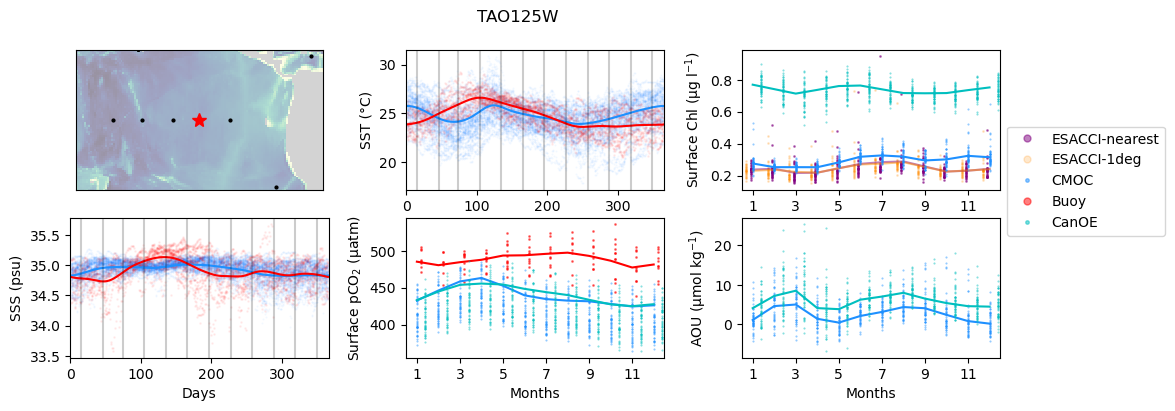

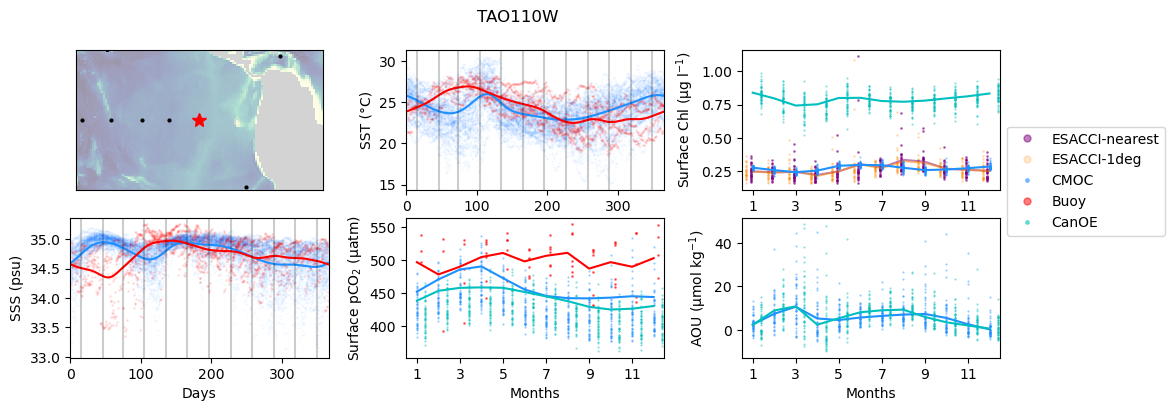

In [19]:
for ind, row in dfb.iterrows():
    fig,ax=plt.subplots(2,3,figsize=(12,4),gridspec_kw={'wspace':.3})
    def _plots(iax,vec,c):
        nmod=len(c.mod_val)
        nobs=np.sum(~np.isnan(c.obs_val))
        iax.plot(c.mod_yind,c.mod_val,'.',color='dodgerblue',ms=1,alpha=min(.05*(2023-1975)*365/nmod,.5),label='CMOC')
        iax.plot(c.obs_yind+.2,c.obs_val,'r.',ms=2,alpha=min(.01*(2023-1975)*365/nobs,.5),label='Buoy')
        iax.plot(vec,c.mod_gsmooth+np.nanmean(c.mod_targetdeseas),'-',color='dodgerblue')
        iax.plot(vec,c.obs_gsmooth+np.nanmean(c.obs_targetdeseas),'r-')
        return
    def _plotAdd(iax,vec,c):
        nmod=len(c.mod_val)
        nobs=np.sum(~np.isnan(c.obs_val))
        iax.plot(c.mod_yind+.4,c.mod_val,'.',color='c',ms=1,alpha=min(.05*(2023-1975)*365/nmod,.5),label='CanOE')
        iax.plot(vec,c.mod_gsmooth+np.nanmean(c.mod_targetdeseas),'-',color='c')
        return
    def _addChl(iax,lat,lon,chfile):
        data0=chfile['chlor_a'].sel(lat=lat,lon=lon,method='nearest').values
        iax.plot(mlist-.1,data0,'.',color='purple',ms=2,alpha=.5,label='ESACCI-nearest')
        data=chfile['chlor_a'].sel(lat=slice(lat+.5,lat-.5),lon=slice(lon-.5,lon+.5)).values
        data1=np.nanmean(np.reshape(data,(len(chfile.time),-1)),axis=-1)
        iax.plot(mlist-.3,data1,'.',color='darkorange',ms=2,alpha=.2,label='ESACCI-1deg')
        iax.plot(np.arange(1,13),[np.nanmean(data0[el::12]) for el in range(0,12)],'-',color='purple',alpha=.5)
        iax.plot(np.arange(1,13),[np.nanmean(data1[el::12]) for el in range(0,12)],'-',color='darkorange',alpha=.5)
    try:
        c=compsD[(row['datasetID'],'tos','daily')]
        _plots(ax[0,1],np.arange(1,366),c)
        for el in mdvec: ax[0,1].axvline(el,color='k',alpha=.2)
        ax[0,1].set_xlim(0,366)
    except KeyError:
        pass
    try:
        c=compsD[(row['datasetID'],'sos','daily')]
        _plots(ax[1,0],np.arange(1,366),c)
        for el in mdvec: ax[1,0].axvline(el,color='k',alpha=.2)
        ax[1,0].set_xlim(0,366)
    except KeyError:
        pass
    try:
        c=compsM[(row['datasetID'],'spco2','monthly')]
        cC=compsMC[(row['datasetID'],'spco2','monthly')]
        _plots(ax[1,1],np.arange(1,13),c)
        _plotAdd(ax[1,1],np.arange(1,13),cC)
        ax[1,1].set_xlim(.5,12.5)
        ax[1,1].set_xticks(np.arange(1,13,2))
    except KeyError:
        pass
    try:
        c=compsM[(row['datasetID'],'chlos','monthly')]
        cC=compsMC[(row['datasetID'],'chlos','monthly')]
        _addChl(ax[0,2],row['Lat'],row['Lon'],fch)
        _plots(ax[0,2],np.arange(1,13),c)
        _plotAdd(ax[0,2],np.arange(1,13),cC)
        ax[0,2].set_xlim(.5,12.5)
        ax[0,2].set_xticks(np.arange(1,13,2))
    except KeyError:
        pass
    try:
        c=compsM[(row['datasetID'],'AOUos','monthly')]
        cC=compsMC[(row['datasetID'],'AOUos','monthly')]
        _plots(ax[1,2],np.arange(1,13),c)
        _plotAdd(ax[1,2],np.arange(1,13),cC)
        ax[1,2].set_xlim(.5,12.5)
        ax[1,2].set_xticks(np.arange(1,13,2))
    except KeyError:
        pass
    fig.suptitle(row['shortTitle'])
    _makemap(ax[0,0],row['ii'],row['jj'],dfb['ii'],dfb['jj'])
    ax[0,1].set_ylabel(bc.dispNameUnits['tos'])
    ax[0,1].set_xlabel('Days')
    ax[1,0].set_ylabel(bc.dispNameUnits['sos'])
    ax[1,0].set_xlabel('Days')
    ax[1,1].set_ylabel(bc.dispNameUnits['spco2'])
    ax[1,1].set_xlabel('Months')
    ax[0,2].set_ylabel(bc.dispNameUnits['chlos'])
    ax[0,2].set_xlabel('Months')
    ax[1,2].set_ylabel(bc.dispNameUnits['AOUos'])
    ax[1,2].set_xlabel('Months')
    ax[0,2].legend(bbox_to_anchor=[1,.5],markerscale=5)